## <a id='contents'> Sleep Mammals Project💤</a>
- [Preprocessing ⚙️](#preprocessing)
    - Import libraries
    - Datasets
    - Replacing 0 values of BrainWt by Nan's 
    - Fillna Dreaming & NonDreaming by the family/order mean values
    - Computing Family, Order, Vore means of "Predation, Exposure, Danger"
    - BrainWt, BodyWt
    - Fillna Predation, Exposure, Danger by the family/order/vore mean values
    - conservation feature
    - BodyWt kg to g
    - LifeSpan years to days
    - Round/Ceil values
    - Summary of variables processing
    - Removing columns for autoML
    - Dataset Summary
    - Drop lines containing outliers (using masks)
    - Pipeline, ColumnTransformer
    
- [🤖 Machine Learning models 🧠](#mlmodels)
    - [A- Linear regression](#LinearRegression) 
    - [B- Decision Tree Regressor - gridSearch](#DecisionTreeRegressor)
    - [C- Gradient Boosting Regressor - gridSearch / RandomizedSearch](#GradientBoostingRegressor)
    - [D- RandomForest - gridSearch](#RandomForest)
    - [E- Features importance](#FeaturesImportance)
    - [F- Predict Dreaming](#Dreaming)
    - [G- Classification problem](#ClassificationProblem)
    - [H- persistence of the dataframe & the models 💾](#Persistence)
        - [H-1 joblib library](#joblib)
        - [H-2 pickle](#pickle)
        - [H-3 save the dataframe as csv file](#csv) 



Advice : when you explore the notebook, click on ⬆️ to come back here.

# <a id='preprocessing'>------------------------------------ Preprocessing ⚙️--------------------------------------</a>   [⬆️](#contents) 

#### 1- import libraries [⬆️](#contents) 

In [1]:
# pandas : data analysis and manipulation tool, numpy : np.nan, np.ceil
import pandas as pd
import numpy as np

# machine learning preprocessing
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# machine learning models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# data split
from sklearn.model_selection import train_test_split

#  machine learning metrics
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error, accuracy_score, f1_score, ConfusionMatrixDisplay

# hide deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

# display
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns

pio.templates["dsti"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "dsti"

from IPython.display import display
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    RED = '\033[91m'
    
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

#### 2- datasets [⬆️](#contents) 

We created three datasets for testing:
- first one, the most complete,
- the second one, the initial dataset with nan's and new boolean column which indicates that we have or not nan's
- and the third one, we transform the problem to a classification problem.

In [2]:
# read the tsv dataset ("tab separated values") with CSV ("comma separated values") function and precise the separator ("\t")
df = pd.read_csv("sleep_merged_LAST.tsv", sep="\t", index_col=0)

# an overview of the dataset
df.head()

,Genus,Family,Order,Vore,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger
Species,,,,,,,,,,,,,,,,
African elephant,Loxodonta,Elephantidae,Proboscidea,herbi,vu,6654.000,5712.0,3.3,20.7,NaN,NaN,38.6,645.0,3.0,5.0,3.0
African giant pouched rat,Cricetomys,Nesomyidae,Rodentia,omni,lc,1.000,6.6,8.3,15.7,6.3,2.0,9.0,42.0,3.0,1.0,3.0
African striped mouse,Rhabdomys,Muridae,Rodentia,omni,lc,0.044,0.0,8.7,15.3,NaN,NaN,4.5,22.0,NaN,NaN,NaN
Arctic fox,Vulpes,Canidae,Carnivora,carni,lc,3.380,44.5,12.5,11.5,NaN,NaN,14.0,60.0,1.0,1.0,1.0
Arctic ground squirrel,Spermophilus,Sciuridae,Rodentia,herbi,lc,0.920,5.7,16.6,7.4,NaN,NaN,10.0,25.0,5.0,2.0,3.0


#### 2-1 second dataset, we'll use it at the end by transforming the problem to a classification problem (convert TotalSleep to 3 classes well represented ~30) [⬆️](#contents) 

In [3]:
df.TotalSleep.value_counts()

TotalSleep
12.5    5
10.1    3
11.0    2
9.1     2
14.4    2
       ..
6.2     1
8.3     1
2.9     1
8.0     1
7.0     1
Name: count, Length: 66, dtype: int64

In [4]:
df_classes = df.copy()

In [5]:
labels = ['ShortSleep', 'AverageSleep', 'LongSleep']
df_classes['TotalSleepClass'] = pd.qcut(df['TotalSleep'], q=3, labels=labels)
df_classes.drop(['TotalSleep'], axis=1, inplace=True)

#### 3- replacing 0 values of BrainWt by Nan's [⬆️](#contents) 

we noticed some species with 0g of Brain, we processed theses values like nan's

In [6]:
df.BrainWt.replace(0, np.nan, inplace=True)

#### 4- Fillna Dreaming & NonDreaming by the family/order mean values [⬆️](#contents) 

In [7]:
df.loc[:, ['Dreaming', 'NonDreaming']] = df[['Dreaming', 'NonDreaming']].replace(np.nan, 0)

In [8]:
# to see which species are concerned
#print(df.loc[(df['Dreaming'] == 0) & (df['NonDreaming'] > 0), 'Dreaming'])
#print(df.loc[(df['Dreaming'] > 0)  & (df['NonDreaming'] == 0), 'NonDreaming'])
#print(df.loc[(df['Dreaming'] == 0)  & (df['NonDreaming'] == 0), ['NonDreaming', 'Dreaming']])

#### 5- case when Dreaming and NonDreaming exist -> TotalSleep = NonDreaming  + Dreaming [⬆️](#contents) 

In [9]:
# verified for some species, and the correct way is the sum of the two indices
df.loc[(df['Dreaming'] > 0) & (df['NonDreaming'] > 0),'TotalSleep'] = df.loc[:,'NonDreaming'] + df.loc[:,'Dreaming']

#### 6- case when we have Dreaming or NonDreaming value [⬆️](#contents) 

In [10]:
df.loc[(df['Dreaming'] == 0) & (df['NonDreaming'] > 0), 'Dreaming'] = df['TotalSleep'] - df['NonDreaming']
df.loc[(df['Dreaming'] > 0)  & (df['NonDreaming'] == 0), 'NonDreaming'] = df['TotalSleep'] - df['Dreaming']

#### 7- computing ratio = Dreaming / NonDreaming [⬆️](#contents) 

In [11]:
df['ratio_D_ND'] = df.Dreaming / df.NonDreaming

#### 8-  Computing Family, Order, Vore means of "Predation, Exposure, Danger, Ratio" [⬆️](#contents) 

In [12]:
Y = ['Family', 'Order', 'Vore', 'Conservation']
mask = Y + ['Predation', 'Exposure', 'Danger', 'ratio_D_ND']

pd.DataFrame([df[mask].groupby([X]).mean(numeric_only=True).isna().sum() for X in Y ], index = Y)
# exists some families, orders with only one species, that's we have Nan's

,Predation,Exposure,Danger,ratio_D_ND
Family,8,8,8,4
Order,2,2,2,0
Vore,0,0,0,0
Conservation,0,0,0,1


In [13]:
df_Family = df[mask].groupby('Family').mean(numeric_only=True)
df_Order =  df[mask].groupby('Order').mean(numeric_only=True)
df_Vore =   df[mask].groupby('Vore').mean(numeric_only=True)

In [14]:
# totalsleep = D + ND
# ratio = D / ND
# ND = D / ratio
# totalsleep = D + D/ratio = (D*ratio + D)/ratio
# D = (totalsleep*ratio)/(1+ratio)

In [15]:
def replace_D_ND_nan():
    df.loc[:, ['Dreaming', 'NonDreaming']] = df[['Dreaming', 'NonDreaming']].replace(np.nan, 0)
    
def replace_D_ND(meanCol,dataframe,mean_ratio_D_ND):
    replace_D_ND_nan()
    df[mean_ratio_D_ND] = df[meanCol].map(dataframe['ratio_D_ND'])
    df.loc[(df['Dreaming'] == 0) & (df['NonDreaming'] == 0), 'Dreaming'] = (df['TotalSleep'] * df[mean_ratio_D_ND])/(1+df[mean_ratio_D_ND])
    df.loc[(df['NonDreaming'] == 0), 'NonDreaming'] = df['TotalSleep'] - df['Dreaming']

When we replace NaNs with the family mean, we still have NaNs, as the table above shows

In [16]:
replace_D_ND('Family',df_Family,'mean_ratio_D_ND_Family')
replace_D_ND('Order',df_Order,'mean_ratio_D_ND_Order')

In [17]:
# to see which species are concerned
#print(df.loc[(df['Dreaming'] == 0) & (df['NonDreaming'] > 0), 'Dreaming'])
#print(df.loc[(df['Dreaming'] > 0)  & (df['NonDreaming'] == 0), 'NonDreaming'])
#print(df.loc[(df['Dreaming'] == 0)  & (df['NonDreaming'] == 0), ['NonDreaming', 'Dreaming']])

#### 9- BrainWt, BodyWt [⬆️](#contents) 

using the mean/median of the ratio brainwt/bodywt, is not really precise
sometimes we will have the half or the double of the real value.
maybe should we use a ML model to predict the value depending the others values

#### 10- Fillna Predation, Exposure, Danger by the family/order/vore mean values [⬆️](#contents) 

In [18]:
def replace_Pred_Exp_Dang_nan():
    df.loc[:, ['Predation','Exposure', 'Danger']] = df[['Predation', 'Exposure', 'Danger']].replace(np.nan, 0)
    
def replace_Pred_Exp_Dang(meanCol, dataframe):
    replace_Pred_Exp_Dang_nan()
    for column in columns_to_update:
        df.loc[df[column] == 0, column] = df[meanCol].map(dataframe[column])

In [19]:
columns_to_update = ['Predation', 'Exposure', 'Danger']

In [20]:
# Fillna Exposure, Predation, Danger by the family mean values
replace_Pred_Exp_Dang('Family',df_Family)

# Fillna Exposure, Predation, Danger by the order mean values
replace_Pred_Exp_Dang('Order',df_Order)

# Fillna Exposure, Predation, Danger by the vore mean values
replace_Pred_Exp_Dang('Vore',df_Vore)

In [21]:
df.drop(['ratio_D_ND','mean_ratio_D_ND_Family', 'mean_ratio_D_ND_Family', 'mean_ratio_D_ND_Order'], axis=1, inplace=True)

#### 11- conservation [⬆️](#contents) 

In [22]:
#sklearn.preprocessing : 
#    - OneHotEncoder -> for input features
#    - LabelEncoder -> for the target in classification problem and not for input features
#    - OrdinalEncoder -> for ordered categories like conservation

In [23]:
df = df.dropna(subset=['Conservation'])

In [24]:
encoder = OrdinalEncoder(categories=[['domesticated', 'lc', 'nt','cd', 'vu', 'en', 'cr']])

df[['Conservation']] = encoder.fit_transform(df[['Conservation']])
print(df[['Conservation']])

                           Conservation
Species                                
African elephant                    4.0
African giant pouched rat           1.0
African striped mouse               1.0
Arctic fox                          1.0
Arctic ground squirrel              1.0
...                                 ...
Vervet                              1.0
Vesper mouse                        1.0
Vole                                1.0
Water opossum                       1.0
Western american chipmunk           1.0

[86 rows x 1 columns]


#### 12- BodyWt kg to g [⬆️](#contents) 

In [25]:
df.BodyWt = df.BodyWt*1000

#### 13- LifeSpan years to days [⬆️](#contents) 

In [26]:
df.LifeSpan = df.LifeSpan*365

#### 14- Round/Ceil values [⬆️](#contents) 

In [27]:
df = df.round(1)
df.loc[:, ['Predation','Exposure', 'Danger']] = df[['Predation', 'Exposure', 'Danger']].apply(np.ceil)

#### 15- Summary of variables processing [⬆️](#contents) 

In [28]:
# Genus        -> deleted
# Family       -> added manually (new variable)
# Order        -> deleted
# Vore    
# Conservation -> completed manually and convert to ordered numeric variable from 1 to 7

# BodyWt       -> converted to g
# BrainWt      -> used the family mean but results are not good. should try ML model

# TotalSleep   -> sum of Dreaming and NonDreaming
# Awake        -> deleted = 24h - TotalSleep
# NonDreaming  -> completed TotalSleep - Dreaming or family/order mean
# Dreaming     -> same as NonDreaming

# LifeSpan     -> completed manually and converted to days
# Gestation    -> completed manually

# Predation    -> used the mean of the family/order/vore
# Exposure     -> used the mean of the family/order/vore
# Danger       -> used the mean of the family/order/vore

df.head()

,Genus,Family,Order,Vore,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger
Species,,,,,,,,,,,,,,,,
African elephant,Loxodonta,Elephantidae,Proboscidea,herbi,4.0,6654000.0,5712.0,3.3,20.7,1.8,1.5,14089.0,645.0,3.0,5.0,3.0
African giant pouched rat,Cricetomys,Nesomyidae,Rodentia,omni,1.0,1000.0,6.6,8.3,15.7,6.3,2.0,3285.0,42.0,3.0,1.0,3.0
African striped mouse,Rhabdomys,Muridae,Rodentia,omni,1.0,44.0,NaN,8.7,15.3,7.4,1.3,1642.5,22.0,4.0,1.0,3.0
Arctic fox,Vulpes,Canidae,Carnivora,carni,1.0,3380.0,44.5,12.5,11.5,9.2,3.3,5110.0,60.0,1.0,1.0,1.0
Arctic ground squirrel,Spermophilus,Sciuridae,Rodentia,herbi,1.0,920.0,5.7,16.6,7.4,12.5,4.1,3650.0,25.0,5.0,2.0,3.0


#### 16- Removing columns [⬆️](#contents) 

In [29]:
# Awake is a repetition of totalsleep = 24h - awake 
# Genus and Order have many unique values according to 
# the length of the dataset
# using gridsearch_rf.best_estimator_.feature_importances_, we noticed that family feature is not relevant
df.drop(['Awake', 'Genus', 'Order'], axis=1, inplace=True)

#### 17- Dataset Summary [⬆️](#contents) 

Display of dataset:


,Family,Vore,Conservation,BodyWt,BrainWt,TotalSleep,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger
Species,,,,,,,,,,,,,
African elephant,Elephantidae,herbi,4.0,6654000.0,5712.0,3.3,1.8,1.5,14089.0,645.0,3.0,5.0,3.0
African giant pouched rat,Nesomyidae,omni,1.0,1000.0,6.6,8.3,6.3,2.0,3285.0,42.0,3.0,1.0,3.0
African striped mouse,Muridae,omni,1.0,44.0,NaN,8.7,7.4,1.3,1642.5,22.0,4.0,1.0,3.0
Arctic fox,Canidae,carni,1.0,3380.0,44.5,12.5,9.2,3.3,5110.0,60.0,1.0,1.0,1.0
Arctic ground squirrel,Sciuridae,herbi,1.0,920.0,5.7,16.6,12.5,4.1,3650.0,25.0,5.0,2.0,3.0


Number of rows is 86

Basics statistics:


,Family,Vore,Conservation,BodyWt,BrainWt,TotalSleep,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger
count,86,86,86.000000,8.600000e+01,63.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
unique,46,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Cricetidae,herbi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,7,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.686047,1.625399e+05,250.273016,10.680233,8.634884,2.045349,6071.308140,127.593023,2.860465,2.186047,2.488372
std,NaN,NaN,1.535935,7.732801e+05,914.350195,4.509254,3.510648,1.424876,5373.154167,135.505058,1.415567,1.384890,1.271814
min,NaN,NaN,0.000000,5.000000e+00,0.100000,1.900000,1.600000,0.000000,547.500000,12.000000,1.000000,1.000000,1.000000
10%,NaN,NaN,0.000000,4.450000e+01,1.000000,3.850000,3.200000,0.500000,912.500000,21.000000,1.000000,1.000000,1.000000
20%,NaN,NaN,1.000000,1.120000e+02,2.540000,6.200000,5.400000,0.800000,1168.000000,25.500000,1.000000,1.000000,1.000000
30%,NaN,NaN,1.000000,3.450000e+02,4.600000,8.500000,7.250000,1.200000,2190.000000,33.000000,2.000000,1.000000,2.000000


Percentage of missing values:


BrainWt    26.74
dtype: float64

C:\Users\douad\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


,Conservation,BodyWt,BrainWt,TotalSleep,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger
Conservation,1.000000,0.260966,0.348670,0.034765,0.033692,0.027010,0.307515,0.364625,0.377512,0.011190,0.287965
BodyWt,0.260966,1.000000,0.946427,0.311128,0.359577,0.098679,0.367399,0.627524,0.040702,0.363942,0.137819
BrainWt,0.348670,0.946427,1.000000,0.357318,0.405433,0.107887,0.523772,0.762953,0.039980,0.407999,0.161193
TotalSleep,0.034765,0.311128,0.357318,1.000000,0.967371,0.781229,0.531276,0.652067,0.245015,0.581722,0.485712
NonDreaming,0.033692,0.359577,0.405433,0.967371,1.000000,0.597577,0.513389,0.648309,0.197157,0.559355,0.421498
Dreaming,0.027010,0.098679,0.107887,0.781229,0.597577,1.000000,0.416407,0.466253,0.289630,0.462800,0.498618
LifeSpan,0.307515,0.367399,0.523772,0.531276,0.513389,0.416407,1.000000,0.754632,0.168181,0.556447,0.090036
Gestation,0.364625,0.627524,0.762953,0.652067,0.648309,0.466253,0.754632,1.000000,0.033342,0.637607,0.281602
Predation,0.377512,0.040702,0.039980,0.245015,0.197157,0.289630,0.168181,0.033342,1.000000,0.493491,0.900880
Exposure,0.011190,0.363942,0.407999,0.581722,0.559355,0.462800,0.556447,0.637607,0.493491,1.000000,0.715946


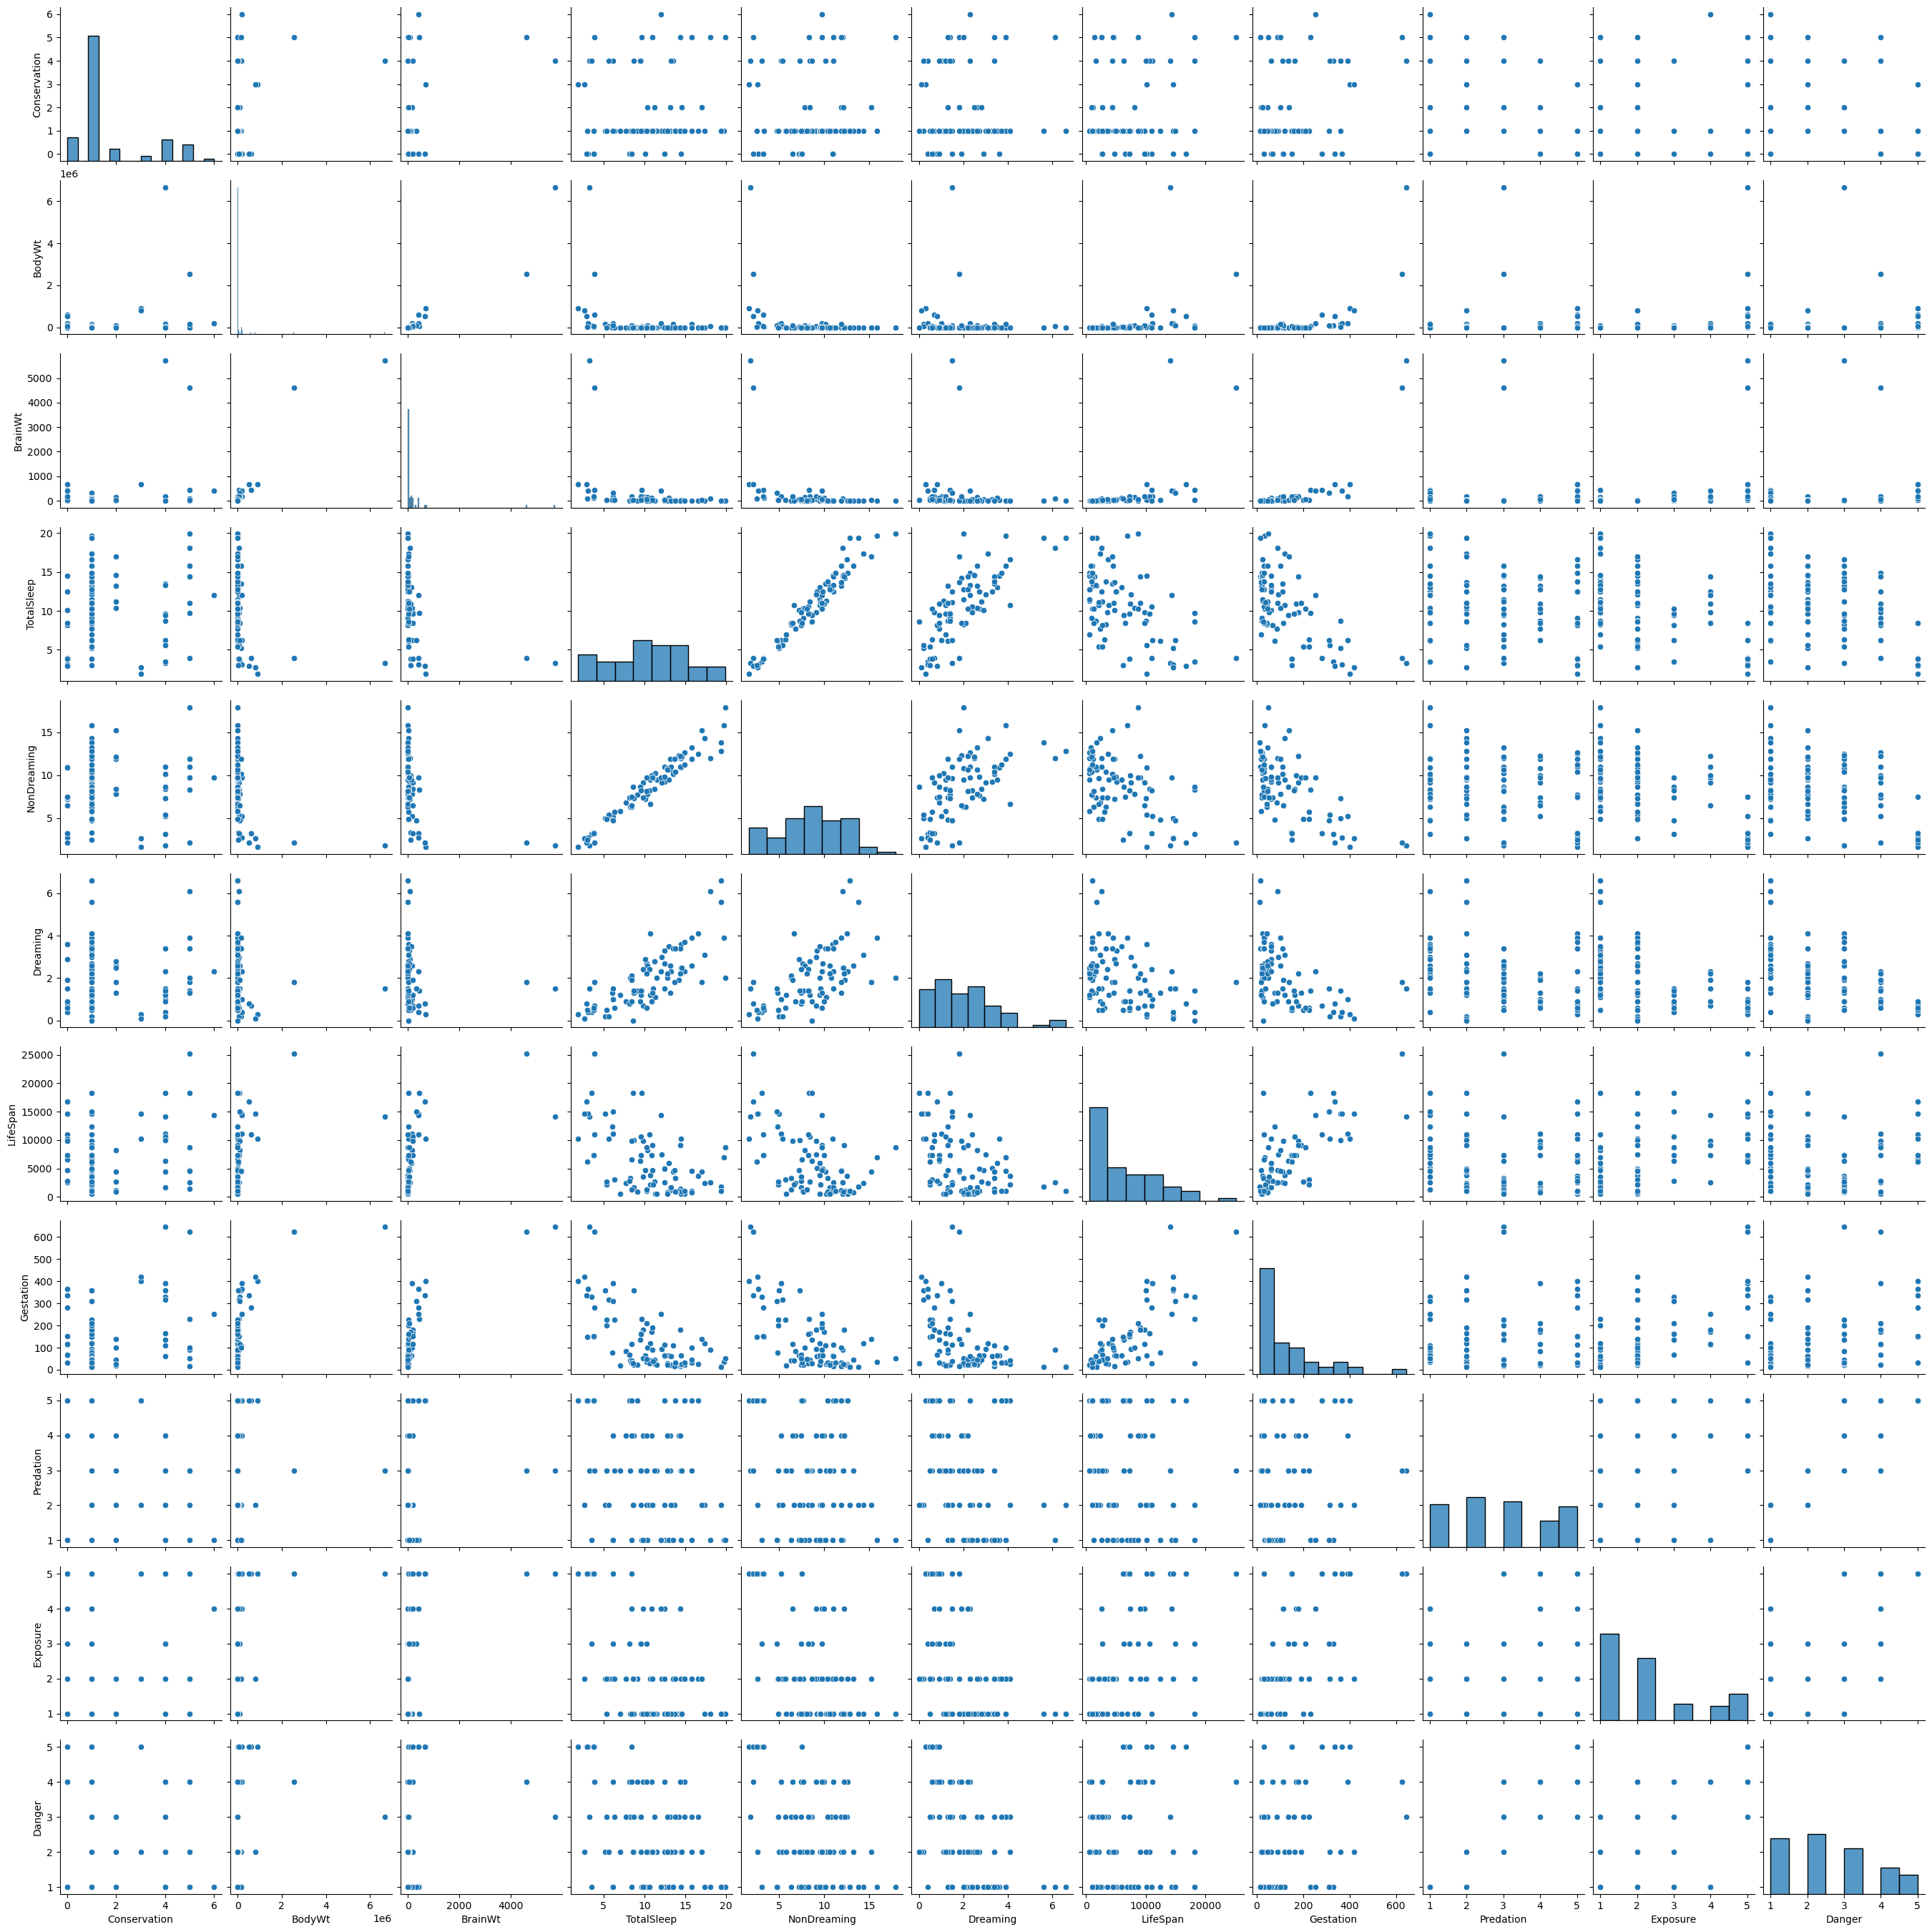

In [30]:
dataset = df

# Basic stats #########################################################################################################
print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKCYAN}Display of dataset:{bcolors.ENDC}")
display(dataset.head())

shape = dataset.shape[0]
print(f"{bcolors.BOLD}{bcolors.OKCYAN}Number of rows is {bcolors.RED}{shape}{bcolors.ENDC}\n")

print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKCYAN}Basics statistics:{bcolors.ENDC}")
display(dataset.describe(percentiles=[0.1,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90],include='all'))

print(f"{bcolors.UNDERLINE}{bcolors.BOLD}{bcolors.OKCYAN}Percentage of missing values:{bcolors.ENDC}")
missing_values = dataset.isnull().sum()
display(round(100*missing_values[missing_values>0]/shape,2))

sns.pairplot(dataset, corner =False)

dataset.corr(numeric_only=True).abs().style.background_gradient()

#### 18- Drop lines containing outliers (using masks) [⬆️](#contents) 

With keeping outliers we have a better R2 score 0.69 instead 0.65 (best model : RandomForestRegressor) but the MAE and MSE are greater than without outliers (x2)

In [31]:
'''outliers = ['BodyWt', 'LifeSpan'] # we'll add 'BrainWt' when we delete 0 values
for outlier in outliers:
    print(f'Dropping outliers in {outlier}...')
    to_keep = dataset[outlier] < dataset[outlier].mean() + 2*dataset[outlier].std()
    dataset = dataset.loc[to_keep,:]
    print('Done. Number of lines remaining : ', dataset.shape[0], '\n')'''

"outliers = ['BodyWt', 'LifeSpan'] # we'll add 'BrainWt' when we delete 0 values\nfor outlier in outliers:\n    print(f'Dropping outliers in {outlier}...')\n    to_keep = dataset[outlier] < dataset[outlier].mean() + 2*dataset[outlier].std()\n    dataset = dataset.loc[to_keep,:]\n    print('Done. Number of lines remaining : ', dataset.shape[0], '\n')"

we selected from the df all numerical columns which are the columns that are from the type int64 and float64
then we dropped the column that seems irrelevant to determine the target y total sleep

Among the dropped columns, 'BrainWt' is specifically excluded due to its NaN values, which our
Linear Regression model cannot process

In [32]:
# Separate target variable Y from features X
target_name = 'TotalSleep'

print("Separating labels from features...")
X = dataset.select_dtypes(include=['int64', 'float64']).drop(['TotalSleep', 'BrainWt', 'Dreaming', 'BodyWt', 'NonDreaming', 'Dreaming'], axis=1)
Y = dataset.loc[:,target_name]

Separating labels from features...


In [33]:
X

,Conservation,LifeSpan,Gestation,Predation,Exposure,Danger
Species,,,,,,
African elephant,4.0,14089.0,645.0,3.0,5.0,3.0
African giant pouched rat,1.0,3285.0,42.0,3.0,1.0,3.0
African striped mouse,1.0,1642.5,22.0,4.0,1.0,3.0
Arctic fox,1.0,5110.0,60.0,1.0,1.0,1.0
Arctic ground squirrel,1.0,3650.0,25.0,5.0,2.0,3.0
...,...,...,...,...,...,...
Vervet,1.0,8760.0,210.0,4.0,3.0,4.0
Vesper mouse,1.0,547.5,19.0,3.0,1.0,2.0
Vole,1.0,547.5,21.0,3.0,1.0,2.0


here we splitted the data into trainig and testing to feed the model with 80% of the whole dataset being used for the training part, 
the remaining 20% will be used to test the efficiency of our model 
A random_state is set for reproducibility of the results

In [34]:
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size= 0.8, random_state=42)

Dividing into train and test sets...


#### 19- sklearn pipeline - preprocessor [⬆️](#contents) 

Before deleting features, we have preprocessed them and tested the models, but the results are not better.
and used the transfomer to discover (at the end of the notebook) the features importance.

In [35]:
'''# Names of categorical columns in X_train/X_test
#categorical_features = ['Vore']

# Names of numeric columns in X_train/X_test
numeric_features = ['Conservation', 'LifeSpan', 'Gestation', 'Exposure', 'Danger']'''

"# Names of categorical columns in X_train/X_test\n#categorical_features = ['Vore']\n\n# Names of numeric columns in X_train/X_test\nnumeric_features = ['Conservation', 'LifeSpan', 'Gestation', 'Exposure', 'Danger']"

In [36]:
'''# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')) # missing values will be replaced by columns' median
    ,('scaler', StandardScaler())
])'''

"# Create pipeline for numeric features\nnumeric_transformer = Pipeline(steps=[\n    ('imputer', SimpleImputer(strategy='median')) # missing values will be replaced by columns' median\n    ,('scaler', StandardScaler())\n])"

In [37]:
'''# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')) # first column will be dropped to avoid creating correlations between features
    ])'''

"# Create pipeline for categorical features\ncategorical_transformer = Pipeline(\n    steps=[\n    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value\n    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')) # first column will be dropped to avoid creating correlations between features\n    ])"

In [38]:
'''# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')'''

"# Create pipeline for categorical features\ncategorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')"

In [39]:
'''# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
        ,('cat', categorical_transformer, categorical_features)
    ])'''

"# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done\npreprocessor = ColumnTransformer(\n    transformers=[\n        ('num', numeric_transformer, numeric_features)\n        ,('cat', categorical_transformer, categorical_features)\n    ])"

when we tranform categorical features and due to the length of the dataset (too small) we have some categories present in the train set and not in the test set, these unknown categories will be encoded as all zeros. Let's see the features importance of the model and maybe the feature is not necessary to predict our targets.

In [40]:
'''# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)

# Preprocessings on test set
print("Performing preprocessings on test set...") 
X_test = preprocessor.transform(X_test)''' 

'# Preprocessings on train set\nprint("Performing preprocessings on train set...")\nX_train = preprocessor.fit_transform(X_train)\n\n# Preprocessings on test set\nprint("Performing preprocessings on test set...") \nX_test = preprocessor.transform(X_test)'

# <a id='mlmodels'>--------------------------- 🤖 Machine Learning Models 🧠 -------------------------- </a>   [⬆️](#contents) 

- [A- Linear regression](#LinearRegression) 
- [B- Decision Tree Regressor - gridSearch](#DecisionTreeRegressor)
- [C- Gradient Boosting Regressor - gridSearch / RandomizedSearch](#GradientBoostingRegressor)
- [D- RandomForest - gridSearch](#RandomForest)
- [E- Features importance](#FeaturesImportance)
- [F- Classification problem](#ClassificationProblem)
- [G- persistence of the dataframe & the models 💾](#Persistence)

## <a id='LinearRegression'>-------------------------------------------------------------------------------------------- A- Linear regression </a>   [⬆️](#contents) 

### A-1 Model training 🏃 [⬆️](#contents) 

some models does not accept missing values encoded as NaN natively. 
For supervised learning, might to consider sklearn.ensemble.HistGradientBoostingRegressor
which accept missing values encoded as NaNs natively.
But in our case we don't have NaN's

Choosing the Linear Regression model for its simplicity and reliability. Linear regression is often considered
the most basic and fundamental model in statistical and machine learning. It's a go-to choice because it works
well as a starting point for many predictive modeling tasks, especially when there is a suspected linear
relationship between the input and output variables

In [41]:
# Train model
model_lr = LinearRegression()

#training the model with the training data. This step involves fitting the model to the training data (X_train, y_train)
print("Training model...")
model_lr.fit(X_train, Y_train) # Training is always done on train set !!

Training model...


LinearRegression()

### A-2 Predictions 🔮 [⬆️](#contents) 

In [42]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model_lr.predict(X_train)

Predictions on training set...


In [43]:
# Predicting the target values for the test dataset. This step evaluates how well our model performs
#on unseen data
print("Predictions on test set...")
Y_test_pred = model_lr.predict(X_test)

Predictions on test set...


### A-3 Performance Evaluation 💯 [⬆️](#contents) 

In [44]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Print scores
print("Score on training set : ", model_lr.score(X_train, Y_train)) # Here, the features must be passed first, and then the true label
print("Score on test set : ", model_lr.score(X_test, Y_test))

#using R2 score to determine how efficient our model is to predict our target variable (the closer R2 is to 1, 
#the more accurate the model is on our data).
r2 = r2_score(Y_test, Y_test_pred)
print('R2 score : ', r2)

#now we're checking the Mean Absolute Error. It tells us how far off our predictions are,
# on average. 
#lower numbers here mean our model's guesses are pretty close to the mark.
mae = mean_absolute_error(Y_test, Y_test_pred)
print('Mean Absolute ERROR: ',  mae)

mse = mean_squared_error(Y_test, Y_test_pred)
print('Mean Squared ERROR: ', mse)

Score on training set :  0.5843937117705251
Score on test set :  0.6110038798429592
R2 score :  0.6110038798429592
Mean Absolute ERROR:  2.78834281137784
Mean Squared ERROR:  11.298416322067432


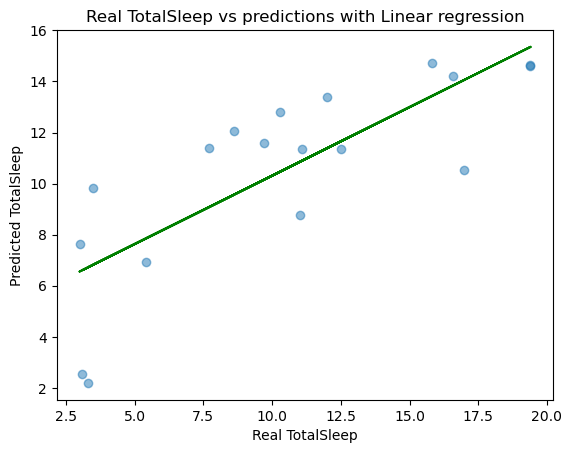

In [45]:
plt.scatter(Y_test, Y_test_pred, alpha=0.5)
plt.title('Real TotalSleep vs predictions with Linear regression')
plt.xlabel('Real TotalSleep')
plt.ylabel('Predicted TotalSleep')

tr = np.polyfit(Y_test, Y_test_pred, 1)
plot = np.poly1d(tr)
plt.plot(Y_test, plot(Y_test), color='green')

plt.show()

## <a id='DecisionTreeRegressor'>---------------------------------------------------------------------------------- B- Decision Tree Regressor</a> [⬆️](#contents) 
                                                                                                              gridSearch 

### B-1 Model training 🏃 [⬆️](#contents) 

After starting with the simple Linear Regression model, we try another model : DecisionTree

In [46]:
# Perform grid search
print("Grid search - DecisionTreeRegressor...")
regressor = DecisionTreeRegressor(random_state=0)

# Grid of values to be tested
params_reg = {
    'max_depth'        :  [1, 2, 3, 4, 6, 8]
    ,'min_samples_leaf' : [1, 2, 3, 4, 5, 6, 7, 9, 11]
    ,'min_samples_split': [2, 4, 8, 9, 10, 11, 12, 13, 14, 15]
}
gridsearch_reg = GridSearchCV(regressor, param_grid = params_reg, cv = 5, n_jobs=-1) # cv : the number of folds to be used for CV
gridsearch_reg.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_reg.best_params_)
print("Best estimator : ", gridsearch_reg.best_estimator_)
print("Best validation score : ", gridsearch_reg.best_score_)

Grid search - DecisionTreeRegressor...
...Done.
Best hyperparameters :  {'max_depth': 1, 'min_samples_leaf': 9, 'min_samples_split': 2}
Best estimator :  DecisionTreeRegressor(max_depth=1, min_samples_leaf=9, random_state=0)
Best validation score :  0.23599433985323498


### B-2 Predictions 🔮 [⬆️](#contents) 

In [47]:
# Predictions on training set
Y_train_pred = gridsearch_reg.predict(X_train)
# Predictions on test set
Y_test_pred = gridsearch_reg.predict(X_test)

### B-3 Performance Evaluation 💯 [⬆️](#contents) 

In [48]:
r2 = r2_score(Y_test, Y_test_pred)
print('R2 score : ', r2)

mae = mean_absolute_error(Y_test, Y_test_pred)
print('Mean Absolute ERROR: ',  mae)

mse = mean_squared_error(Y_test, Y_test_pred)
print('Mean Squared ERROR: ', mse)

R2 score :  0.27415680312157775
Mean Absolute ERROR:  3.978695260610154
Mean Squared ERROR:  21.082160458469385


## <a id='GradientBoostingRegressor'>--------------------------------------------------------------------------- C- Gradient Boosting Regressor </a> [⬆️](#contents)
                                                                                            gridSearch / RandomizedSearch  

### C-1 Model training 🏃 [⬆️](#contents) 

After testing with the simpler Linear Regression model and the more complex DecisionTreeRegressor, we decided 
to test the GradientBoostingRegressor next. This choice was motivated by its advanced ability to handle complex, 
non-linear relationships through a sequential model-building process where each new model corrects errors made 
by the previous ones. Known for its precision in making highly accurate predictions, Gradient Boosting offers 
an ensemble technique that can potentially outperform our earlier models by addressing both bias and variance 
more effectively.

Choosing GridSearchCV to optimize our model for predicting 'total sleep'. This tool helps us find the best
hyperparameters by testing various combinations, ensuring our model is as accurate as possible. It's crucial
for complex predictions like total sleep.

You can also use RandomizedSearchCV() if you don't have enough resources (memory, cpu..)

In [49]:
# Perform grid search
print("Grid search - GradientBoostingRegressor...")
gboost = GradientBoostingRegressor(random_state=0)
params_g = {
    'learning_rate': [0.1, 0.2,0.3,0.4]
    ,'n_estimators': [1,2,5,7,10,30,50,300]
    ,'max_depth'   : [1,5,7,11,12,13,14,15]
}
gridsearch_gb = GridSearchCV(gboost, param_grid = params_g, cv = 3, n_jobs=-1) # cv : the number of folds to be used for CV
gridsearch_gb.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_gb.best_params_)
print("Best estimator : ", gridsearch_gb.best_estimator_)
print("Best validation score : ", gridsearch_gb.best_score_)

Grid search - GradientBoostingRegressor...
...Done.
Best hyperparameters :  {'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 10}
Best estimator :  GradientBoostingRegressor(learning_rate=0.3, max_depth=1, n_estimators=10,
                          random_state=0)
Best validation score :  0.3054567748859259


### C-2 Predictions 🔮 [⬆️](#contents) 

In [50]:
# Predictions on training set
Y_train_pred = gridsearch_gb.predict(X_train)
# Predictions on test set
Y_test_pred = gridsearch_gb.predict(X_test)

### C-3 Performance Evaluation 💯 [⬆️](#contents) 

In [51]:
r2 = r2_score(Y_test, Y_test_pred)
print('R2 score : ', r2)

mae = mean_absolute_error(Y_test, Y_test_pred)
print('Mean Absolute ERROR: ',  mae)

mse = mean_squared_error(Y_test, Y_test_pred)
print('Mean Squared ERROR: ', mse)

R2 score :  0.5944391915340628
Mean Absolute ERROR:  2.953464028546132
Mean Squared ERROR:  11.779538716510952


## <a id='RandomForest'> ------------------------------------------------------------------------------------------------ D- RandomForest </a> [⬆️](#contents)
                                                                                                               gridSearch

### D-1 Model training 🏃 [⬆️](#contents) 

We decided to advance to the RandomForestRegressor
because of its superior ability than DecisionTree and LinearRegression to handle complex and non-linear relationships between features.

In [52]:
# Perform grid search
print("Grid search - RandomForestRegressor...")
regressor_rf = RandomForestRegressor()
params = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [None, 10, 20],      
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]     
}

gridsearch_rf = GridSearchCV(regressor_rf, param_grid = params,scoring='neg_mean_squared_error', cv = 5, n_jobs=-1) # cv : the number of folds to be used for CV
gridsearch_rf.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_rf.best_params_)
print("Best validation accuracy : ", gridsearch_rf.best_score_)

Grid search - RandomForestRegressor...
...Done.
Best hyperparameters :  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best validation accuracy :  -12.008870360064813


In [53]:
# Predictions on training set
Y_train_pred = gridsearch_rf.predict(X_train)
# Predictions on test set
Y_test_pred = gridsearch_rf.predict(X_test)

r2 = r2_score(Y_test, Y_test_pred)
print('R2 score : ', r2)

mae = mean_absolute_error(Y_test, Y_test_pred)
print('Mean Absolute ERROR: ',  mae)

mse = mean_squared_error(Y_test, Y_test_pred)
print('Mean Squared ERROR: ', mse)

R2 score :  0.6337163594639323
Mean Absolute ERROR:  2.6991256172839506
Mean Squared ERROR:  10.638730949471352


#### RandomForest without GridSearchCV

In [54]:
rf = RandomForestRegressor(random_state=42)

#teaching the RandomForest model with our training data
rf.fit(X_train, Y_train)

# Predictions on training set
Y_train_pred = rf.predict(X_train)
# Predictions on test set
Y_test_pred = rf.predict(X_test)

r2 = r2_score(Y_test, Y_test_pred)
print('R2 score : ', r2)

mae = mean_absolute_error(Y_test, Y_test_pred)
print('Mean Absolute ERROR: ',  mae)

mse = mean_squared_error(Y_test, Y_test_pred)
print('Mean Squared ERROR: ', mse)

R2 score :  0.6935063380119232
Mean Absolute ERROR:  2.338963888888886
Mean Squared ERROR:  8.902127331805541


## <a id='FeaturesImportance'> --------------------------------------------------------------------------------------- E- Features importance </a> [⬆️](#contents)

In [55]:
'''column_names = []
for name, step, features_list in preprocessor.transformers_: # loop over steps of ColumnTransformer
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = step.get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)'''

'column_names = []\nfor name, step, features_list in preprocessor.transformers_: # loop over steps of ColumnTransformer\n    if name == \'num\': # if pipeline is for numeric variables\n        features = features_list # just get the names of columns to which it has been applied\n    else: # if pipeline is for categorical variables\n        features = step.get_feature_names_out() # get output columns names from OneHotEncoder\n    column_names.extend(features) # concatenate features names\n        \nprint("Names of columns corresponding to each coefficient: ", column_names)'

In [56]:
'''# Create a pandas DataFrame
feature_importance = pd.DataFrame(index = column_names, data = gridsearch_rf.best_estimator_.feature_importances_, columns=["feature_importances"])
feature_importance = feature_importance.sort_values(by = 'feature_importances')'''

'# Create a pandas DataFrame\nfeature_importance = pd.DataFrame(index = column_names, data = gridsearch_rf.best_estimator_.feature_importances_, columns=["feature_importances"])\nfeature_importance = feature_importance.sort_values(by = \'feature_importances\')'

In [57]:
'''# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, margin = {'l': 120}) # to avoid cropping of column names
fig.show()'''

"# Plot coefficients\nfig = px.bar(feature_importance, orientation = 'h')\nfig.update_layout(showlegend = False, margin = {'l': 120}) # to avoid cropping of column names\nfig.show()"

#### We choose the last and best model : randomForest, to display the important features

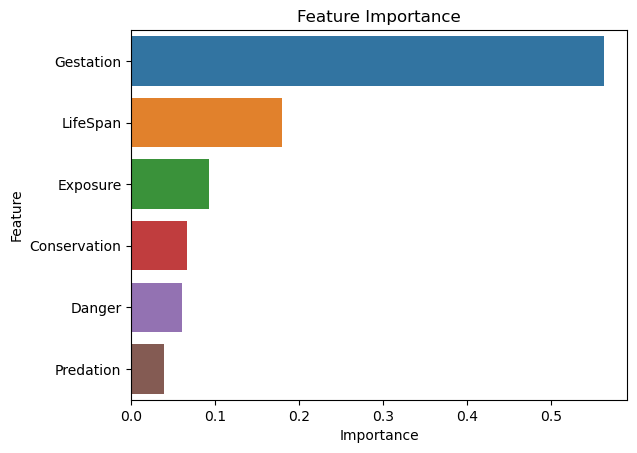

In [58]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

## <a id='Dreaming'> ------------------------------------------------------------------------------------------- F- Predict Dreaming </a> [⬆️](#contents)

## Now, let's predict dreaming:

In [59]:
#selecting specific features for our model: Gestation, Predation, Exposure, and Danger. These predictors
#are chosen based on their potential relevance to the target variable, 'Dreaming'. The hypothesis is
#that these features have a significant impact on the amount of dreaming an animal experiences

X = df[['Gestation',"Predation", "Exposure", "Danger", 'TotalSleep']]

#setting the target variable y  = 'dreaming ' so that we can predict it with the features variable X 
y = df['Dreaming']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, random_state= 42)

In [60]:
X.head()

,Gestation,Predation,Exposure,Danger,TotalSleep
Species,,,,,
African elephant,645.0,3.0,5.0,3.0,3.3
African giant pouched rat,42.0,3.0,1.0,3.0,8.3
African striped mouse,22.0,4.0,1.0,3.0,8.7
Arctic fox,60.0,1.0,1.0,1.0,12.5
Arctic ground squirrel,25.0,5.0,2.0,3.0,16.6


#### F-1 LINEAR REGRESSION MODEL (less performant of the 3)

In [61]:
Lr = LinearRegression()
Lr.fit(X_train, y_train)

y_pred = Lr.predict(X_test)

r2 = r2_score(y_test, y_pred)
print('R2 score : ', r2)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute ERROR: ',  mae)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared ERROR: ', mse)

R2 score :  0.6910558961725963
Mean Absolute ERROR:  0.8141754511290861
Mean Squared ERROR:  1.0098658070417488


#### F-2 RANDOM FOREST REGRESSOR

In [62]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute ERROR: ',  mae)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

R2 Score: 0.8300174415530464
Mean Absolute ERROR:  0.5232222222222216
Mean Squared Error: 0.5556331111111099


#### F-3 GRADIENT BOOSTING REGRESSOR 

In [63]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute ERROR: ',  mae)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

R2 Score: 0.8537389901428425
Mean Absolute ERROR:  0.4850406017238662
Mean Squared Error: 0.4780929330849333


## <a id='ClassificationProblem'> ------------------------------------------------------------------------------------ G- Classification problem </a> [⬆️](#contents) 
                                                                                                               gridSearch

### G-1 preprocessing ⚙️ model training 🏃 [⬆️](#contents) 

As mentionned above, we decide to start exploring the classification case.

In [64]:
# Separate target variable Y from features X
target_name = 'TotalSleepClass'

print("Separating labels from features...")
Y = df_classes.loc[:,target_name]
X = df_classes.drop(target_name, axis = 1) # All columns are kept, except the target

print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")


# Names of categorical columns in X_train/X_test
categorical_features = ['Family', 'Vore', 'Conservation']

# Names of numeric columns in X_train/X_test
numeric_features = ['BodyWt', 'BrainWt', 'LifeSpan', 'Gestation', 'Predation', 'Exposure', 'Danger']

# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')) # missing values will be replaced by columns' median
    ,('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore') 

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)

# Label encoding
print("Encoding labels...")
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)

# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test)

# Label encoding
print("Encoding labels...")
Y_test = encoder.transform(Y_test)

Separating labels from features...
Dividing into train and test sets...
...Done.
Performing preprocessings on train set...
Encoding labels...
Performing preprocessings on test set...
Encoding labels...


C:\Users\douad\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:227: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [65]:
# Perform grid search
print("Grid search - RandomForestClassifier...")
classifier_rf = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60]
}
gridsearch_cl = GridSearchCV(classifier_rf, param_grid = params, cv = 3, n_jobs=-1) # cv : the number of folds to be used for CV
gridsearch_cl.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch_cl.best_params_)
print("Best validation accuracy : ", gridsearch_cl.best_score_)

Grid search - RandomForestClassifier...
...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 40}
Best validation accuracy :  0.6521739130434783


### G-2 Predictions 🔮 [⬆️](#contents) 

In [66]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch_cl.predict(X_train)

Predictions on training set...


In [67]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch_cl.predict(X_test)

Predictions on test set...


### G-3 Performance Evaluation 💯 [⬆️](#contents) 

In [68]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred, average='weighted'))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred,average='weighted'))

accuracy on training set :  0.9130434782608695
accuracy on test set :  0.6111111111111112
f1-score on training set :  0.9135776561039356
f1-score on test set :  0.6107744107744106


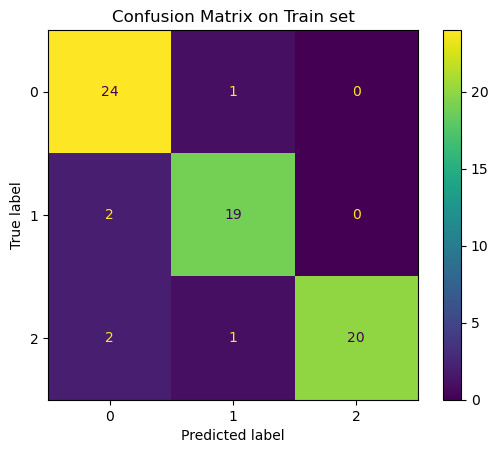

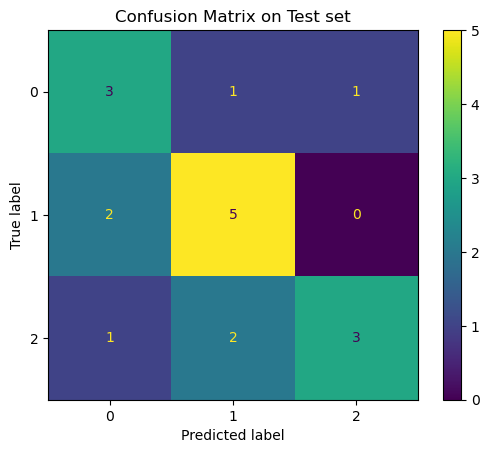

In [69]:
# Visualize confusion matrices
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_cl, X_train, Y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_cl, X_test, Y_test, ax=ax)
plt.show()

## <a id='Persistence'>  --------------------------------------------------- H- Persistence of the dataframe & the models 💾  </a> [⬆️](#contents) 

### <a id='joblib'>H-1 joblib library </a> [⬆️](#contents) 

In [70]:
# create a list to persist the models used at the same time
models_list = [model_lr, gridsearch_gb.best_estimator_, gridsearch_reg.best_estimator_]
version = 0.0

In [71]:
from joblib import dump, load

for model in models_list:
    # save the model
    name = f'sleepMammals_{str(model).strip("_")[0]}_{version+0.1}.joblib'
    dump(model, name)

    # load the model
    load_joblib_model = load(name)
    #print(load_joblib_model,'\t', type(load_joblib_model))

#the instruction to predict after load the joblib model
#load_joblib_model.predict(X_train)

### <a id='pickle'> H-2 pickle library </a> [⬆️](#contents) 

In [72]:
import pickle

# save the model
pkl_model = pickle.dumps(model_lr)

# load the model
s = pickle.loads(pkl_model)
type(s)

sklearn.linear_model._base.LinearRegression

### <a id='csv'> H-3 save the dataframe as csv file </a> [⬆️](#contents) 

In [73]:
# save your new dataset
#dataset.to_csv('sleep_mammals_new.csv', index=True)